# Real Time Visual Tracking with RRN

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import glob
import cv2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import shutil

In [4]:
#shutil.unpack_archive("/content/drive/MyDrive/Deep Learning - Fall 22'/Final Project/Code/Dataset_Sequential.zip", "Dataset_Sequential")

## METHODS

In [5]:
def data_loader(num_imgs, path): 
  image_list_all = []
  for i in range(num_imgs): 
    image_list_all.append(np.asarray(Image.open((path + str(i) + ".jpeg"))).astype('float32')/255)
  
  data = np.asarray(image_list_all)
  del image_list_all

  labels = pd.read_csv(path + "detection_boxes.csv")
  labels = np.asarray(labels)
  labels = labels[:num_imgs, 1:]
  
  # Data Normalization
  data = (data.reshape(num_imgs, -1) - np.mean(data)) / np.std(data)
  labels = labels.reshape(num_imgs, -1) / img_size

  x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2)
  del data, labels

  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)

  return x_train, y_train, x_val, y_val, x_test, y_test

In [6]:
def IOU(bbox1, bbox2):
  """
  Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity
  
  """
  # Predicted Block
  x1 = bbox1[0]
  y1 = bbox1[3]
  w1 = bbox1[2] - bbox1[0]
  h1 = bbox1[1] - bbox1[3]

  # Real Block
  x2 = bbox2[0]
  y2 = bbox2[3]
  w2 = bbox2[2] - bbox2[0]
  h2 = bbox2[1] - bbox2[3]

  w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
  h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
  if w_I <= 0 or h_I <= 0:  # no overlap
      return 0.
  I = w_I * h_I
  U = w1 * h1 + w2 * h2 - I

  result = I / U

  return result

## CODE

In [7]:
# Parameters
epochs = 150
batch_size = 8
img_size = 400
num_imgs = 5000
num_objects = 1

path = "/content/Dataset_Sequential/Dataset_Sequential/"

# Method Calls
x_train, y_train, x_val, y_val, x_test, y_test = data_loader(num_imgs, path)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(3000, 160000)
(3000, 4)
(1000, 160000)
(1000, 4)
(1000, 160000)
(1000, 4)


## BUILD THE NETWORK & TRAIN IT

In [8]:
# Build the model.
model = Sequential()
model.add(layers.Dense(400, activation='relu', input_dim=x_train.shape[-1]))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(y_train.shape[-1]))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.01, rho=0.95, epsilon=1e-07), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(x_val, y_val), verbose=2) 

Epoch 1/150
375/375 - 12s - loss: 0.0808 - accuracy: 0.5000 - val_loss: 0.0185 - val_accuracy: 0.6990 - 12s/epoch - 33ms/step
Epoch 2/150
375/375 - 9s - loss: 0.0416 - accuracy: 0.5560 - val_loss: 0.0114 - val_accuracy: 0.6890 - 9s/epoch - 23ms/step
Epoch 3/150
375/375 - 8s - loss: 0.0366 - accuracy: 0.5787 - val_loss: 0.0098 - val_accuracy: 0.7350 - 8s/epoch - 20ms/step
Epoch 4/150
375/375 - 8s - loss: 0.0323 - accuracy: 0.6000 - val_loss: 0.0075 - val_accuracy: 0.7340 - 8s/epoch - 22ms/step
Epoch 5/150
375/375 - 8s - loss: 0.0290 - accuracy: 0.6197 - val_loss: 0.0065 - val_accuracy: 0.8890 - 8s/epoch - 21ms/step
Epoch 6/150
375/375 - 8s - loss: 0.0272 - accuracy: 0.6347 - val_loss: 0.0086 - val_accuracy: 0.7630 - 8s/epoch - 20ms/step
Epoch 7/150
375/375 - 8s - loss: 0.0255 - accuracy: 0.6417 - val_loss: 0.0058 - val_accuracy: 0.8700 - 8s/epoch - 20ms/step
Epoch 8/150
375/375 - 8s - loss: 0.0267 - accuracy: 0.6510 - val_loss: 0.0054 - val_accuracy: 0.8270 - 8s/epoch - 21ms/step
Epoch 

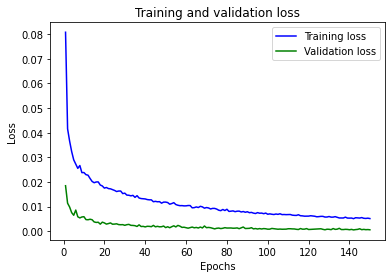

In [9]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss') #blue dots
plt.plot(epochs, val_loss, 'g', label='Validation loss') #blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

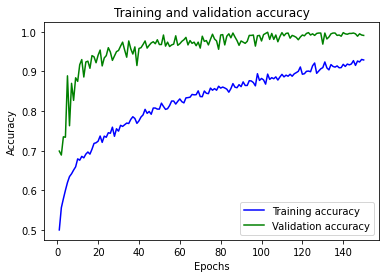

In [10]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy') #blue dots
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy') #blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## EVALUATE THE RESULTS

In [11]:
# Predict with the testing data. 
predictions = model.predict(x_test)

32/32 [==============================] - 0s 12ms/step


In [12]:
# Resize the data. 
predictions *= img_size
predictions = predictions.reshape(len(predictions), num_objects, -1)

In [13]:
y_test *= img_size

# Calculate the real accuracy of the model -  With the mean IOU
Accomulated_IOU = 0.
for predicted_value, real_value in zip(predictions.reshape(-1, 4), y_test.reshape(-1, 4)):
  Accomulated_IOU += IOU(predicted_value, real_value)
mean_IOU = Accomulated_IOU / len(predictions)
print("Actual accuracy level of the system: ", mean_IOU)

Actual accuracy level of the system:  0.5040869654983103


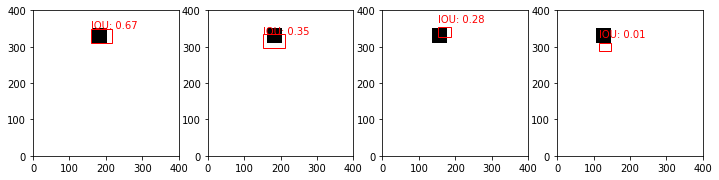

In [14]:
# Show a few images and predicted bounding boxes from the test dataset. 
x_test = x_test.reshape(len(x_test), img_size, img_size)
y_test = y_test.reshape(len(y_test), num_objects, 4)

plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(x_test))
    plt.imshow(x_test[i], cmap=plt.cm.get_cmap('Greys').reversed(), interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(predictions[i], y_test[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[3]), pred_bbox[2]-pred_bbox[0], pred_bbox[1] - pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[3] + 40), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

## SAVE THE MODEL

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               64000400  
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 204       
                                                                 
Total params: 64,105,954
Trainable params: 64,105,954
No

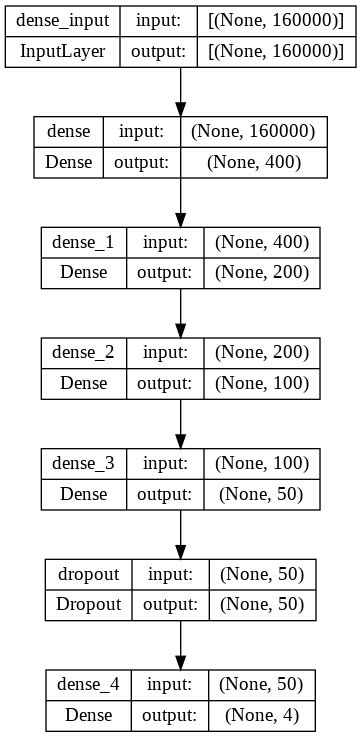

In [20]:
from keras.utils.vis_utils import plot_model
from IPython.display import display, Image
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_plot.png'))

In [15]:
model.save('basic_model.hdf5')